# Let's build all kind of auto-de models.

In [29]:
#imports
import os
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from ioh_xplainer import explainer
import pandas as pd
import ioh
from scipy.stats import qmc
from ConfigSpace import ConfigurationSpace
from ConfigSpace.util import generate_grid
from IPython.display import display
from time import monotonic
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib import pyplot as plt

In [15]:
ela_df = pd.read_pickle("ela-features.pkl")
features= ['mutation_base', 'mutation_reference',
       'mutation_n_comps', 'use_archive', 'crossover', 'adaptation_method',
       'lpsr']
ela_df.describe()

        mutation_base mutation_reference  mutation_n_comps  use_archive  \
0              target              pbest                 1         True   
1              target              pbest                 1         True   
2              target              pbest                 1         True   
3              target              pbest                 1         True   
4              target              pbest                 1         True   
...               ...                ...               ...          ...   
1359355        target              pbest                 2        False   
1359356        target              pbest                 2        False   
1359357        target              pbest                 2        False   
1359358        target              pbest                 2        False   
1359359        target              pbest                 2        False   

        crossover adaptation_method   lpsr  dim  ela_distr.skewness  \
0             exp           

,mutation_n_comps,dim,fid,iid,auc,ela_meta.lin_simple.adj_r2,ela_meta.lin_simple.intercept,ela_meta.lin_simple.coef.min,ela_meta.lin_simple.coef.max,ela_meta.lin_simple.coef.max_by_min,...,disp.diff_median_05,disp.diff_median_10,disp.diff_median_25,disp.costs_runtime,ic.h_max,ic.eps_s,ic.eps_max,ic.eps_ratio,ic.m0,ic.costs_runtime
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,...,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,1.420168,17.500000,12.529412,2.983193,6271.617906,0.415939,0.306031,0.001585,0.020391,208.855841,...,-2.226518,-1.822927,-1.228216,0.066090,0.814488,-1.163979,0.008995,-1.970500,0.570751,17.531552
std,0.494626,12.526344,6.958374,1.411126,2217.138544,0.309497,0.213423,0.002628,0.017609,602.809588,...,1.195817,0.981489,0.646552,0.020165,0.047347,0.394779,0.010292,0.461801,0.061397,15.829076
min,1.000000,5.000000,1.000000,1.000000,2308.641975,-0.012387,0.006332,0.000001,0.001866,1.180272,...,-4.332638,-3.542501,-2.382481,0.039957,0.661395,-1.956957,0.000030,-4.139139,0.445892,1.316971
25%,1.000000,5.000000,6.250000,2.000000,4386.882716,0.074840,0.147449,0.000103,0.006671,10.000000,...,-3.239734,-2.694112,-1.823422,0.050578,0.781022,-1.516517,0.003488,-2.137137,0.506263,1.839350
50%,1.000000,17.500000,13.000000,3.000000,5546.604938,0.445528,0.275287,0.000402,0.014511,38.558495,...,-2.250866,-1.779900,-1.182159,0.060897,0.819140,-1.316316,0.005281,-2.017017,0.585170,16.444365
75%,2.000000,30.000000,18.750000,4.000000,8297.530864,0.667934,0.395027,0.001933,0.029578,120.840372,...,-1.464608,-1.194742,-0.824243,0.079777,0.856508,-0.815816,0.011563,-1.656657,0.613727,32.137450
max,2.000000,30.000000,24.000000,5.000000,10000.000000,1.000000,0.972162,0.013651,0.102430,4335.993230,...,0.487208,0.316937,0.231666,0.146778,0.888130,-0.255255,0.066654,-0.995996,0.710421,40.080469


In [16]:
#load explainer
data_file = "mod_de_all.pkl" #read in modular DE data
df = pd.read_pickle(data_file)

config_dict = {}
for f in features:
    config_dict[f] = list(map(str, df[f].unique()))

config_dict['mutation_n_comps'] = [1,2]
config_dict['use_archive'] = [False, True]
config_dict['lpsr'] = [False, True]

#for each fid, iid get the best configuration  (mean?)
cs = ConfigurationSpace(config_dict)

print(cs)

de_explainer = explainer(None, 
                 cs , 
                 algname="mod-DE",
                 dims = [5,30],#, 10, 20, 40 
                 fids = np.arange(1,25), #,5
                 iids = df['iid'].unique(), #20 
                 reps = len( df['seed'].unique()), 
                 sampling_method = "grid",  #or random
                 grid_steps_dict = {},
                 sample_size = None,  #only used with random method
                 budget = 10000, #10000
                 seed = 1,
                 verbose = True)
de_explainer.load_results(data_file)

Configuration space object:
  Hyperparameters:
    adaptation_method, Type: Categorical, Choices: {nan, jDE, shade}, Default: nan
    crossover, Type: Categorical, Choices: {exp, bin}, Default: exp
    lpsr, Type: Categorical, Choices: {False, True}, Default: False
    mutation_base, Type: Categorical, Choices: {target, best, rand}, Default: target
    mutation_n_comps, Type: Categorical, Choices: {1, 2}, Default: 1
    mutation_reference, Type: Categorical, Choices: {pbest, rand, nan, best}, Default: pbest
    use_archive, Type: Categorical, Choices: {False, True}, Default: False



In [4]:
for f in features:
    print(f, ela_df[f].unique())

mutation_base ['best' 'rand' 'target']
mutation_reference ['rand' 'pbest' 'best']
mutation_n_comps [1 2]
use_archive [False  True]
crossover ['bin' 'exp']
adaptation_method ['shade' 'jDE']
lpsr [False  True]


5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24


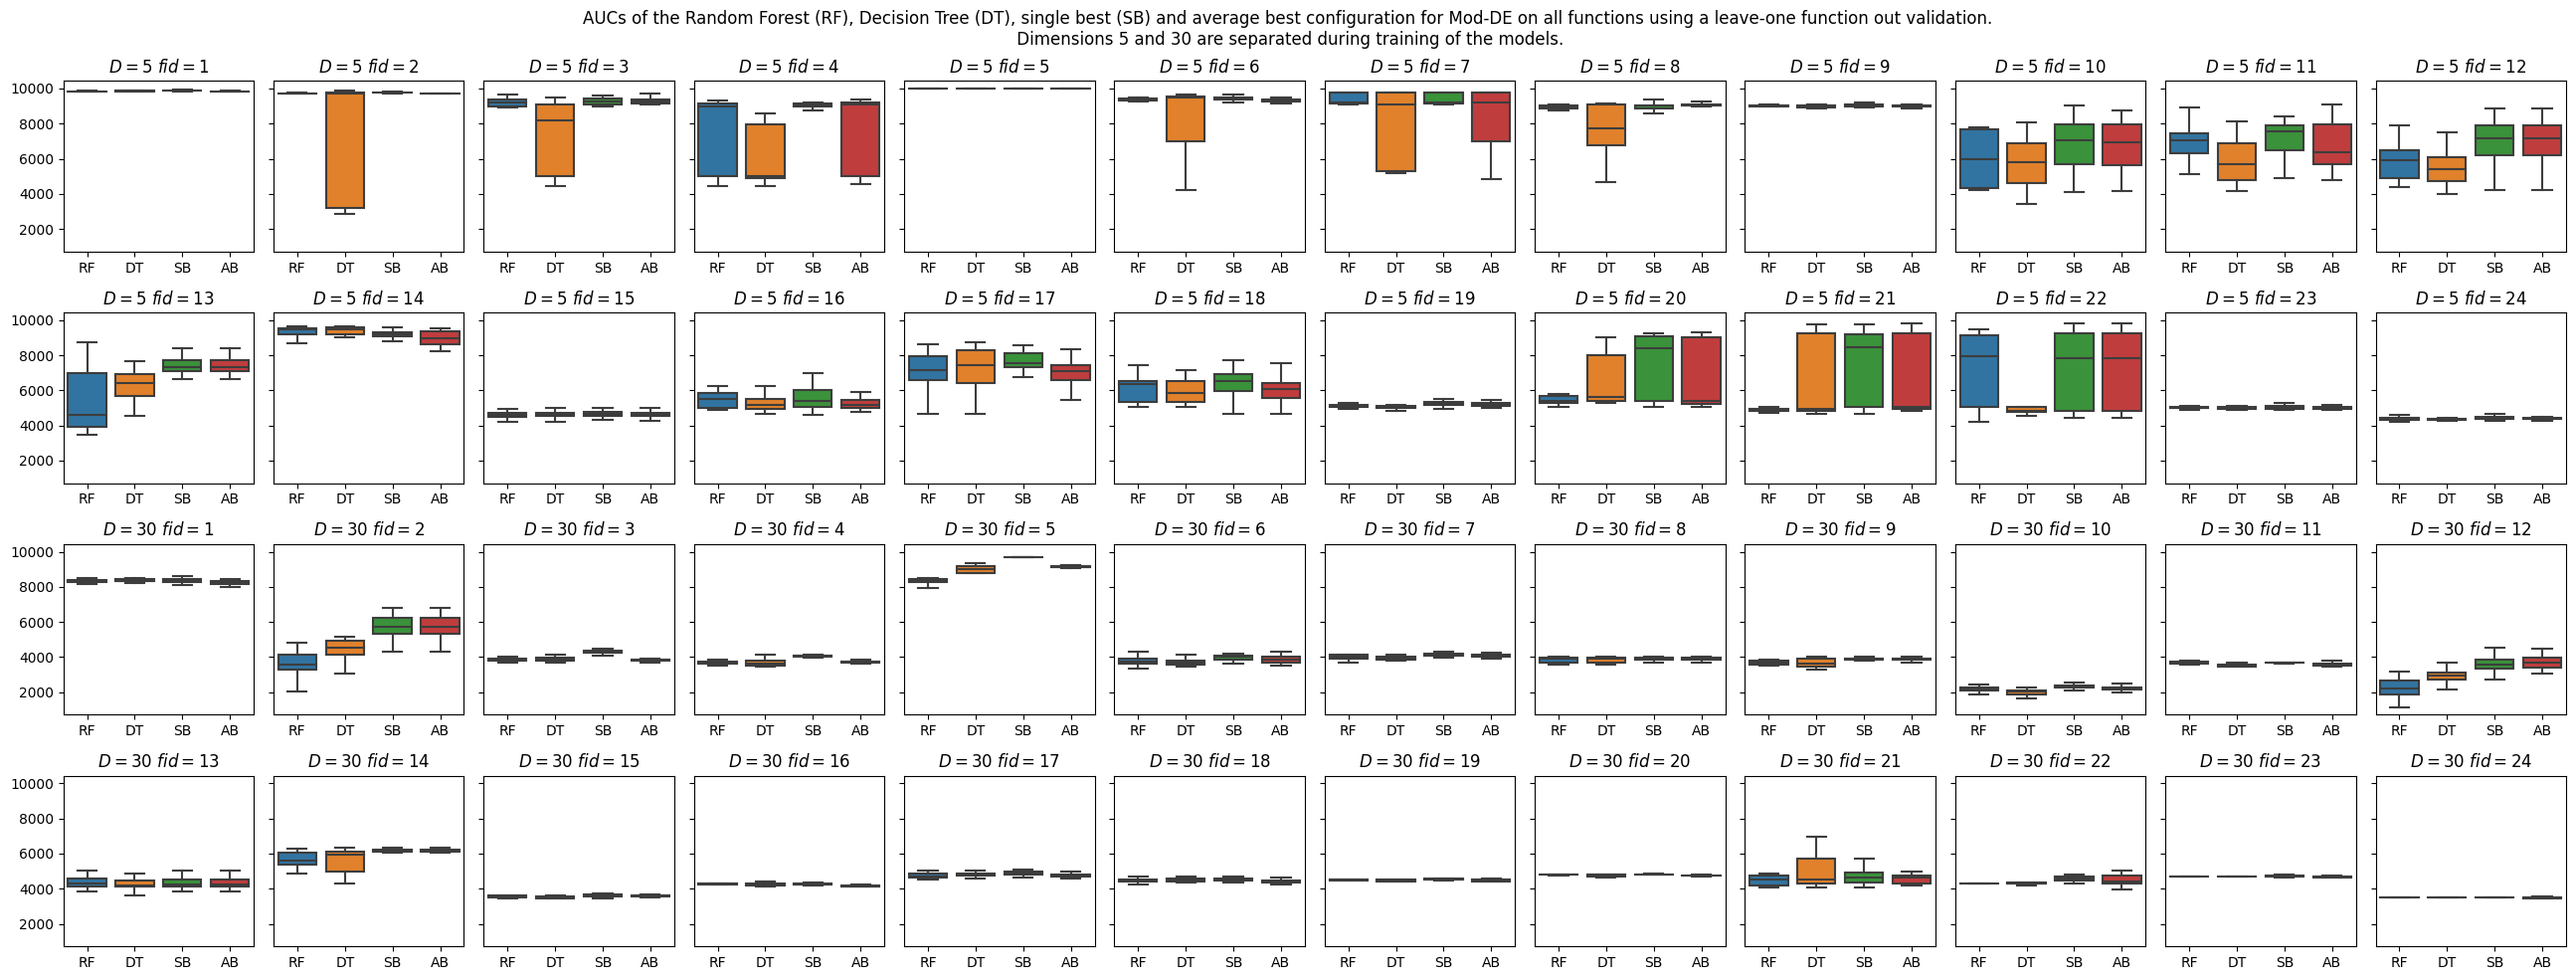

In [36]:
def predToNames(y):
    mapping = [['best', 'rand', 'target'], ['best', 'pbest', 'rand'], [1, 2], [False, True], ['bin', 'exp'], ['jDE', 'shade'], [False, True]]
    newy = {}
    i = 0
    for f in features:
        newy[f] = mapping[i][y[i]]
        i+=1
    #transform a numerical representation back to the categorical names
    return newy

from matplotlib import pyplot as plt
import seaborn as sns

#preprocess the data to train and test
fig, axes = plt.subplots(4, 12, sharey=True, figsize=(26,10))
fig.suptitle('AUCs of the Random Forest (RF), Decision Tree (DT), single best (SB) and average best configuration for Mod-DE on all functions using a leave-one function out validation.\n Dimensions 5 and 30 are separated during training of the models.')

dim_counter = 0
for dim in ela_df['dim'].unique():
    _, df_avg_best = de_explainer.get_average_best(dim)
    
    for fid in ela_df['fid'].unique():
        print(dim, fid)
        box_plot_df = pd.DataFrame(columns=['RF', 'DT','SB','AB'])

        _, df_single_best = de_explainer.get_single_best(fid, dim)
        box_plot_df['SB'] = df_single_best['auc'].values
        box_plot_df['AB'] = df_avg_best[df_avg_best['fid'] == fid]['auc'].values

        df = ela_df[ela_df['dim'] == dim]
        X_train = df[df['fid'] != fid].copy().drop(['fid','iid','auc',*features], axis=1)
        y_train = df[df['fid'] != fid][features]
        X_test = df[df['fid'] == fid].copy().drop(['fid','iid','auc',*features], axis=1)
        y_test = df[df['fid'] == fid][features]

        X_train.replace([np.inf, -np.inf], 0, inplace=True)
        X_test.replace([np.inf, -np.inf], 0, inplace=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

        y_train[features] = y_train[features].apply(lambda col:pd.Categorical(col).codes)
        y_test[features] = y_test[features].apply(lambda col:pd.Categorical(col).codes)
    
        dtree = DecisionTreeClassifier(max_depth=7)
        dtree.fit(X_train, y_train)
        y_pred = dtree.predict(X_test)

        #RF
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        y_red_rf = rf.predict(X_test)

        iid = 1
        all_aucs = []
        all_aucs_rf = []
        for y in y_pred:
            #print(y)
            conf = predToNames(y)
            #print(conf)
            aucs = de_explainer.get_results_for_config(conf, dim, fid, iid)
            all_aucs.extend(aucs.values)
            #print(all_aucs)
        for y in y_red_rf:
            #print(y)
            conf = predToNames(y)
            #print(conf)
            aucs = de_explainer.get_results_for_config(conf, dim, fid, iid)
            all_aucs_rf.extend(aucs.values)
            #print(all_aucs)

        box_plot_df['DT'] = np.array(all_aucs)[:len(box_plot_df)]
        box_plot_df['RF'] = np.array(all_aucs_rf)[:len(box_plot_df)]
        sns.boxplot(ax=axes[dim_counter + int((fid-1)/12)][(fid-1)%12], data=box_plot_df, showfliers = False)  
        axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_title(f"$D={dim}$ $fid={fid}$")
        #axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_xticklabels(axes[dim_counter + int((fid-1)/12)][(fid-1)%12].get_xticks(), rotation=45)
    dim_counter += 2

plt.tight_layout()
plt.show()

plt.clf()
plt.close()

        